# Michelle Helfman Term Project

# Predicting Possible Bank Failures Using the Percentage of Assets to Deposits.

In [1]:
# Import Functions

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
import yellowbrick

from matplotlib.patches import Wedge
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ROCAUC

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Display all rows and columns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
# Set the custom color palette

colors = sns.color_palette('bright')[0:5]
sns.set_palette(colors)
red = "#FF0B04"
blue = "#4374B3"
purple = "#782F98"
green = "#00CC66"

line_colors = ['blue', 'cyan', 'green', 'red',
               'skyblue', 'brown', 'purple',
               'black', 'grey', 'orange', 'maroon',
               'lightgreen']

# Term Project Milestone 1

In [4]:
# Read in the Bank information file and print the 1st 10 rows.
fdic_info_df = pd.read_excel("FDIC_Bank_info.xlsx")

new_col_headers = {'id': 'ID', 'institution_name': 'Institution_Name', 
                   'city': 'City', 'state': 'State', 'class': 'Class', 
                   'total_assets': 'Total_Assets', 'total_deposits': 'Total_Deposits', 
                   'asset_deposit_ratio': 'Asset_Deposit_PCT', 
                   'population': 'Population', 'remaining_pct': 'Remaining_PCT', 
                   'bank_type': 'Bank_Type','minimum_pct': 'Minimum_PCT', 
                   'status': 'Status'}
fdic_info_df.rename(columns = new_col_headers, inplace = True)

# Split the FDIC info into Active and Failed banks
active_df = fdic_info_df[fdic_info_df['Status'] == 'ACTIVE']
failure_df = fdic_info_df[fdic_info_df['Status'] == 'FAILURE']

print('1st 10 Rows')
print(fdic_info_df[['Institution_Name','Class','Bank_Type','Total_Assets',
                    'Total_Deposits','Asset_Deposit_PCT','Remaining_PCT',
                    'Population', 'Status']].head(10))

1st 10 Rows
                             Institution_Name       Class  Bank_Type  \
0  F & M COMMUNITY BANK, NATIONAL ASSOCIATION  COMMERCIAL  COMMUNITY   
1                          RANDALL STATE BANK  COMMERCIAL  COMMUNITY   
2            FARMERS STATE BANK OF ROUND LAKE  COMMERCIAL  COMMUNITY   
3                         PRIME SECURITY BANK  COMMERCIAL  COMMUNITY   
4                               ALLIANCE BANK  COMMERCIAL  COMMUNITY   
5                        CENTER NATIONAL BANK  COMMERCIAL  COMMUNITY   
6                                    ESB BANK  COMMERCIAL  COMMUNITY   
7                SECURITY STATE BANK OF OKLEE  COMMERCIAL  COMMUNITY   
8                     SECURITY BANK MINNESOTA  COMMERCIAL  COMMUNITY   
9             TOWN & COUNTRY BANK OF ALMELUND  COMMERCIAL  COMMUNITY   

   Total_Assets  Total_Deposits  Asset_Deposit_PCT  Remaining_PCT  Population  \
0        194856          174679              89.65          10.35     5707390   
1         55767           50382  

## Predicting Possible Bank Failures Based on the Percentage of Assets-to-Deposits.

You started a new business, won money on a lottery scratch-off ticket, have a checking account to receive your paycheck and pay your bills, or you're teaching your children about money with their first savings account.  These are some of the reasons people put money in banks.  

Traditional brick-and-mortar banks are everywhere, from big cities to small towns; some have branches in other countries.  Accessing bank accounts can be done through the Internet, smartphone applications, or just going to the bank to use an ATM or speak directly to a person (teller).  

The United States guarantees your money is safe through the Federal Deposit Insurance Corporation (FDIC).  The Banking Act of 1933 created the FDIC during the Great Depression to restore faith and trust in the United States' banking system.  In 1933, the insurance limit was only \\$2,500.  Now deposit accounts are insured for up to \\$250,000.  The FDIC has regulations to ensure banks have enough assets to cover deposits.  What happens when banks do not have enough assets to maintain the level of deposits?  Another bank acquires that bank, or it fails.

When a bank fails, accounts are frozen, companies can't make payroll, and customers can't pay their bills or pay for necessities.   Even though your deposits are insured, a great deal of hassle, fear, and uncertainty is still part of a bank failure.  Are there warning signs that signify that a bank might be in trouble?

The FDIC requires its member banks to provide a quarterly report of assets and deposits.  A report summary is available to the general public through their website ([FDIC - Current Financial & Regulatory Data](https://banks.data.fdic.gov/bankfind-suite/financialreporting?charterClass=ALL&charteringAgency=ALL&commonSearchesExpand=true&establishedDateRangeExpand=true&establishedEndRange=6%2F26%2F2023&establishedStartRange=01%2F01%2F1792&inactiveDateRangeExpand=true&inactiveEndRange=6%2F26%2F2023&inactiveStartRange=01%2F01%2F1970&incomeBasis=YTD&institutionType=banks&limitEstablishedDate=false&limitInactiveDate=false&pageNumber=1&primaryRegulator=ALL&regulatoryExpand=true&reportPeriod=20230331&resultLimit=25&sortField=CERT&sortOrder=ASC&unitType=%24)).  Then by dividing the total assets by the total deposits, you can see the percentage of deposits to the amount of assets.  If the percentage is below 90%, there are plenty of assets to cover your deposits.  Between 92% and 100%, there may not be enough "wiggle room" for a horrible investment not to affect your account, and above 100%, your money may not be accessible without FDIC participation.

The FDIC provides the same asset and deposit information on failed banks ([FDIC - Bank Failures & Assistance Data](https://banks.data.fdic.gov/explore/failures/?aggReport=detail&displayFields=NAME%2CCERT%2CFIN%2CCITYST%2CFAILDATE%2CSAVR%2CRESTYPE%2CCOST%2CRESTYPE1%2CCHCLASS1%2CQBFDEP%2CQBFASSET&endFailYear=2023&sortField=FAILDATE&sortOrder=desc&startFailYear=1960)).  Since 1960, 3080 banks have failed; is it possible to use this past and present information to predict which banks need a detailed assessment before depositing your money into or removing all your funds from these institutions?

## Graphical Analysis of the FDIC Information

There various ways of looking at solvent and failure bank information:  by Status, by Bank Type, by Charter Class, by Assets-to-Deposits Percentages, state population, and by which States have the most currently active and previously failed.

Below are examples of Bank Type, Charter Class, Assets-to-Deposits Percentages, and State counts grouped together by Active or Failed Status.

In [5]:
# Count status by bank type

# Group the counts by status and bank type
bt_counts = fdic_info_df.groupby(['Status', 
                            'Bank_Type'])['ID'].count()

print('Bank Status by Bank Type')
bt_counts

Bank Status by Bank Type


Status   Bank_Type
ACTIVE   COMMUNITY    4519
         NATIONAL       33
         REGIONAL      129
FAILURE  COMMUNITY    3009
         NATIONAL        5
         REGIONAL       19
Name: ID, dtype: int64

In [6]:
# Find the minimum and maximum deposits for Active Banks

min_deposits = active_df['Total_Deposits'].min()
max_deposits = active_df['Total_Deposits'].max()

print('Minimum Deposit Amount in Thousands = ', min_deposits)
print('Maximun Deposit Amount in Thousands = ', max_deposits)

Minimum Deposit Amount in Thousands =  443
Maximun Deposit Amount in Thousands =  2043645952


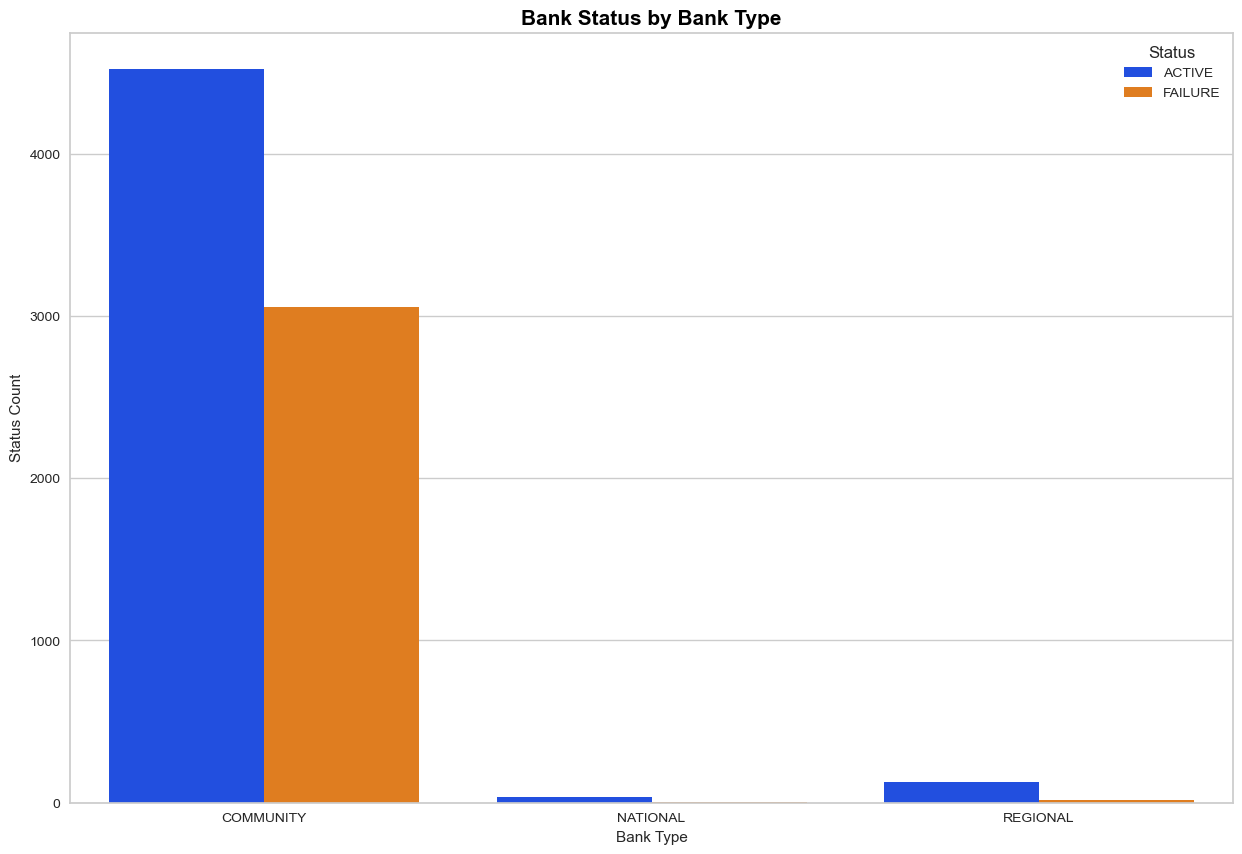

In [7]:
# Graph the Status by Bank Type counts

fig, axes = plt.subplots(figsize=(15, 10))
hue_order = ['ACTIVE', 'FAILURE']

bt_countplot = sns.countplot(data = fdic_info_df, x = 'Bank_Type',  
                             hue = 'Status', dodge = True)
                             #dict(edgecolor="black", linewidth=2))
bt_countplot.set_title('Bank Status by Bank Type', 
                      fontdict={'size': 15, 'weight': 'bold', 'color': 'black'})
bt_countplot.set(xlabel='Bank Type', ylabel='Status Count')
 
# Show the plot
plt.show()

## Commentary

Banks are divided into 3 types:  Community, Regional, and National.  These types are based on the level of deposits.  Community banks have deposits less than \\$10 billion.  Regional banks are larger with deposits between \\$10 billion and \\$100 billion and possibly branches in multiple states.  National banks have deposits greater than \\$100 billion and could be located in countries outside of the United States.  Community banks account for 95% of all banks, they are local in small towns and big cities with total deposits as little as \\$443,000.  Community banks are also responsible for 95% of all failures.  Regional banks are medium in size and make up less than 2% of bank failures and National banks account for the rest.    

In [8]:
# Count status by bank charter class

# Group the counts by status and charter class
class_counts = fdic_info_df.groupby(['Status', 
                            'Class'])['ID'].count()

print('Bank Status by Charter Class')
class_counts

Bank Status by Charter Class


Status   Class     
ACTIVE   COMMERCIAL    4133
         FOREIGN          9
         SAVINGS        539
FAILURE  COMMERCIAL    2010
         OTHER            1
         SAVINGS       1022
Name: ID, dtype: int64

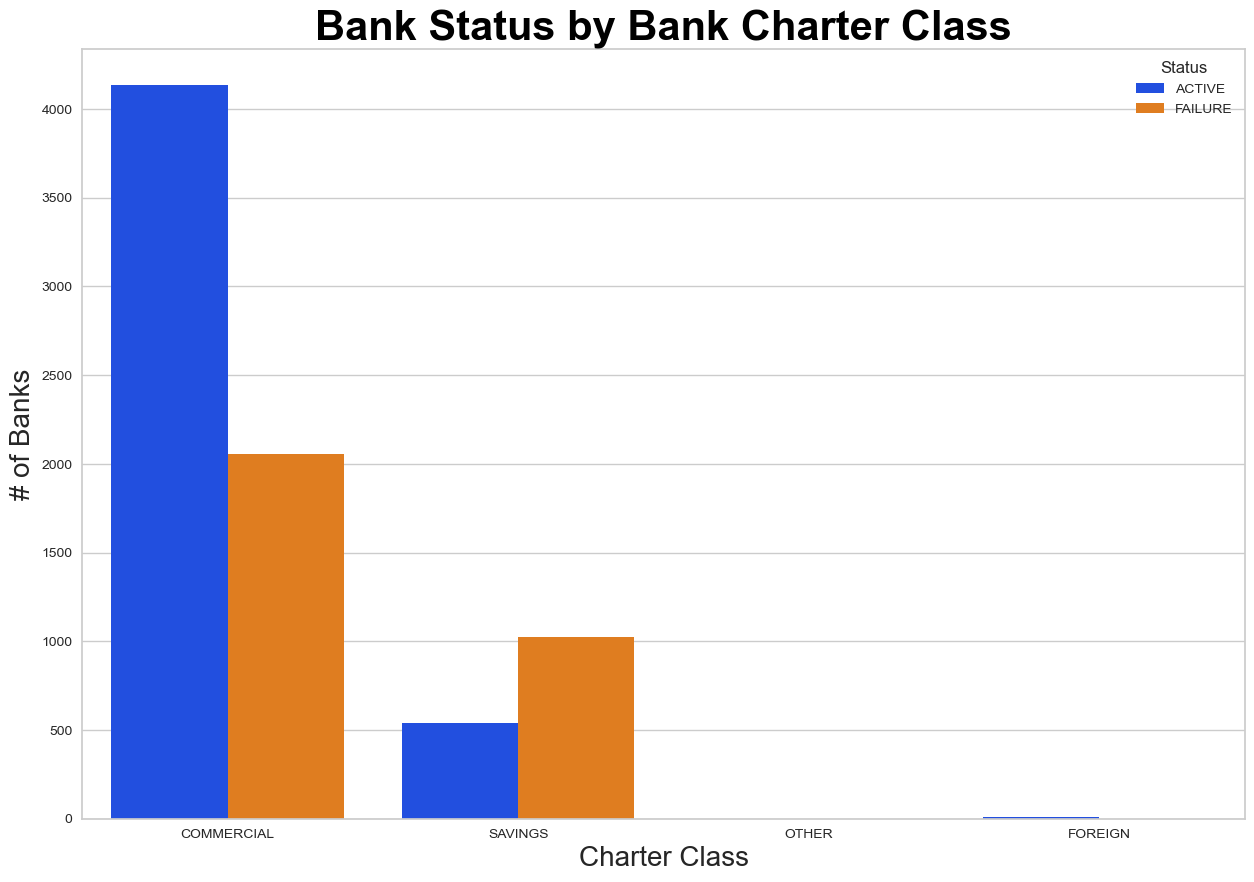

In [9]:
# Graph the Status by Bank Charter Class counts

fig, axes = plt.subplots(figsize=(15, 10))
hue_order = ['ACTIVE', 'FAILURE']

class_countplot = sns.countplot(data = fdic_info_df, x = 'Class',  
                             hue = 'Status', dodge = True)
class_countplot.set_title('Bank Status by Bank Charter Class', 
                      fontdict={'size': 30, 'weight': 'bold',  'color': 'black'})
axes.set_xlabel('Charter Class', fontsize = 20)
axes.set_ylabel('# of Banks', fontsize = 20)
 
# Show the plot
plt.show()

## Commentary

Commercial banks are primarily Community banks.  These banks concentrate on larger businesses and make up the 66% of bank failures.  Savings & Loans are more traditional, focussing on residential mortgage, smaller business with a local customer base.  S&Ls comprise the remaining 33% of bank failures.

In [10]:
# Find the records that have the are most likely to Fail

high_pcts = fdic_info_df.nlargest(10,'Asset_Deposit_PCT')
print(high_pcts[['Institution_Name', 'Status', 'Bank_Type', 'Class', 
                   'Asset_Deposit_PCT', 'Remaining_PCT']].to_string(index=False))

                 Institution_Name  Status Bank_Type   Class  Asset_Deposit_PCT  Remaining_PCT
             NEW METROPOLITAN FSB FAILURE COMMUNITY SAVINGS             234.35        -134.35
           GOLDEN TRIANGLE S & LA FAILURE COMMUNITY SAVINGS             229.44        -129.44
             AMERICAN OF ANADARKO FAILURE COMMUNITY SAVINGS             221.76        -121.76
                   SEAPOINTE S&LA FAILURE COMMUNITY SAVINGS             218.43        -118.43
                   TERRITORY S&LA FAILURE COMMUNITY SAVINGS             217.50        -117.50
      FIRST SAVINGS OF EAST TEXAS FAILURE COMMUNITY SAVINGS             214.78        -114.78
EVANGELINE FEDERAL SAVINGS & LOAN FAILURE COMMUNITY SAVINGS             212.38        -112.38
 FIRST SAVINGS OF AMERICA FS & LA FAILURE COMMUNITY SAVINGS             201.12        -101.12
     SECURITY SAVINGS ASSOCIATION FAILURE COMMUNITY SAVINGS             199.47         -99.47
        REPUBLIC BANK FOR SAVINGS FAILURE COMMUNITY SAVINGS 

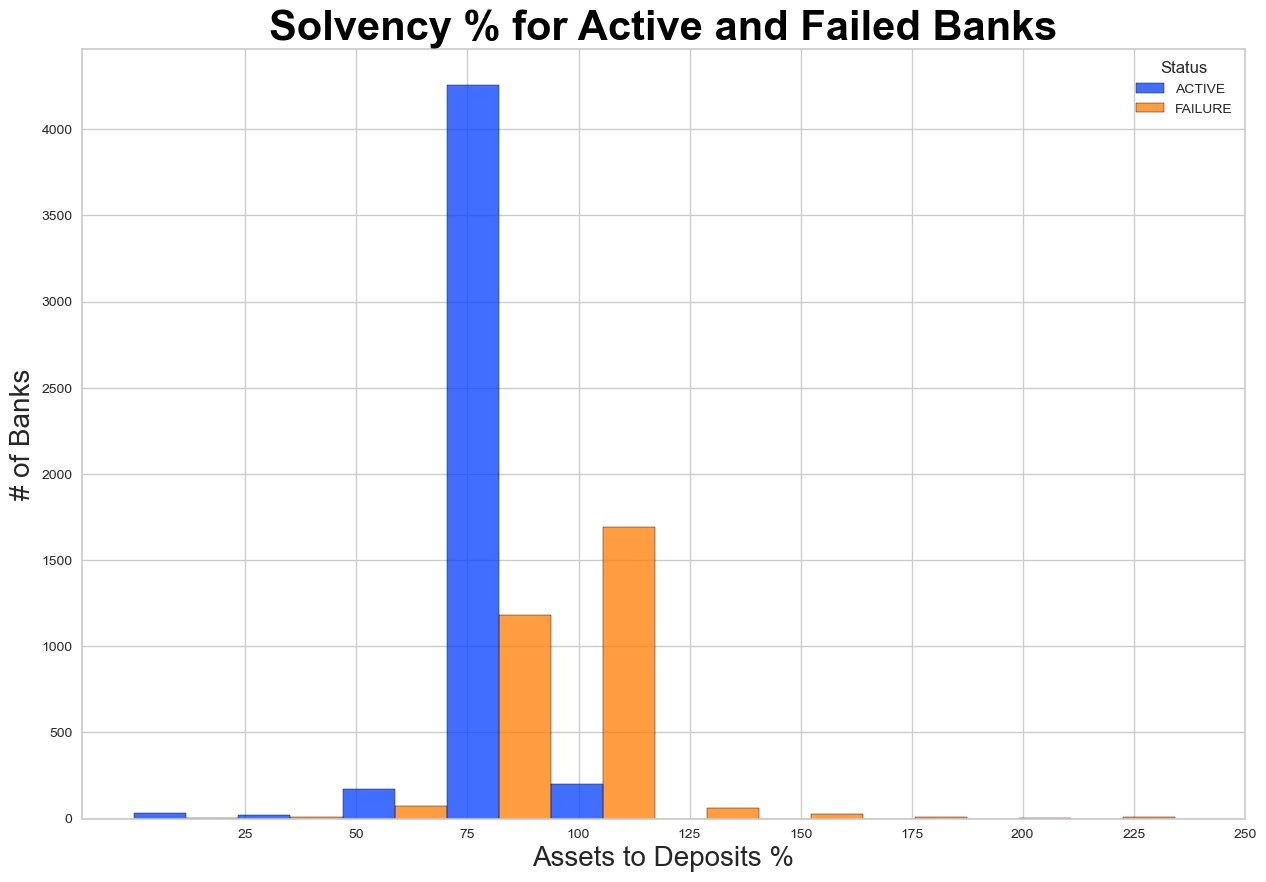

In [11]:
# Plot the Asset to Deposit Percentage by Status.

fig, axes = plt.subplots(figsize=(15, 10))

ad_pct_hist = sns.histplot(data=fdic_info_df, x='Asset_Deposit_PCT', 
                            bins=10, hue = 'Status', multiple = 'dodge')
ad_pct_hist.set_title('Solvency % for Active and Failed Banks', 
                      fontdict={'size': 30, 'weight': 'bold',  'color': 'black'})
axes.set_xlabel('Assets to Deposits %', fontsize = 20)
axes.set_ylabel('# of Banks', fontsize = 20)
plt.xticks([25, 50, 75, 100, 125, 150, 175, 200, 225, 250])
plt.show()

## Commentary

Most of the currently solvent banks have an asset-to-deposit percentage of approximately 75%, meaning all the deposits are covered by the available assets.  The current banks that are approaching 100% are those that would require a more detailed review looking for other contributing factors for the high asset to deposit percentage.  The majority of failures have a asset to deposit percentage approaching or above 100%.  With some as high as 225%, these banks could not cover the value of their deposits with a guarantee from the FDIC.  

## The next 3 graphs look at information from the state level, comparing solvent banks, failed banks, and population.

Solvent banks and failures as well as state populations are displayed separately due to the large number of states and territories in the United States.

In [12]:
# Set up Active and Failed Banks counts and State Population

# Group the counts by status and charter class
#type_class_counts = fdic_info_df.groupby(['Status', 
#                                          'State'])['ID'].count().reset_index(name='Counts')


active_counts_df = active_df.groupby(['State'])['ID'].count().reset_index(name='Counts')
failure_counts_df = failure_df.groupby(['State'])['ID'].count().reset_index(name='Counts')

# Get the distinct state and population information
# Drop the duplicates and sort by state
state_population_df = fdic_info_df[['State','Population']].copy()
state_population_df = state_population_df.drop_duplicates()
state_population_df = state_population_df.sort_values(by=['State'])

In [13]:
# Print Largest and Smallest State Populations

print('States With The Largest and Smallest State Populations')
print('Largest Population')
state_population_df.nlargest(10,'Population')

States With The Largest and Smallest State Populations
Largest Population


,State,Population
524,CA,39237836
28,TX,29527941
404,FL,21781128
95,NY,19835913
24,PA,12964056
52,IL,12671469
179,OH,11780017
50,GA,10799566
23,NC,10551162
68,MI,10050811


In [14]:
# States with least amount of active banks
print('Smallest Population')
state_population_df.nsmallest(10,'Population')

Smallest Population


,State,Population
856,FM,47329
2713,VI,87146
2769,GU,153836
315,WY,578803
950,VT,645570
632,DC,670050
496,AK,732673
97,ND,774948
27,SD,895376
362,DE,1003384


In [15]:
# Average state populations 

st_pop_cnts = state_population_df.median()
print('The Average State Population = ', st_pop_cnts)

The Average State Population =  Population    3986639.0
dtype: float64


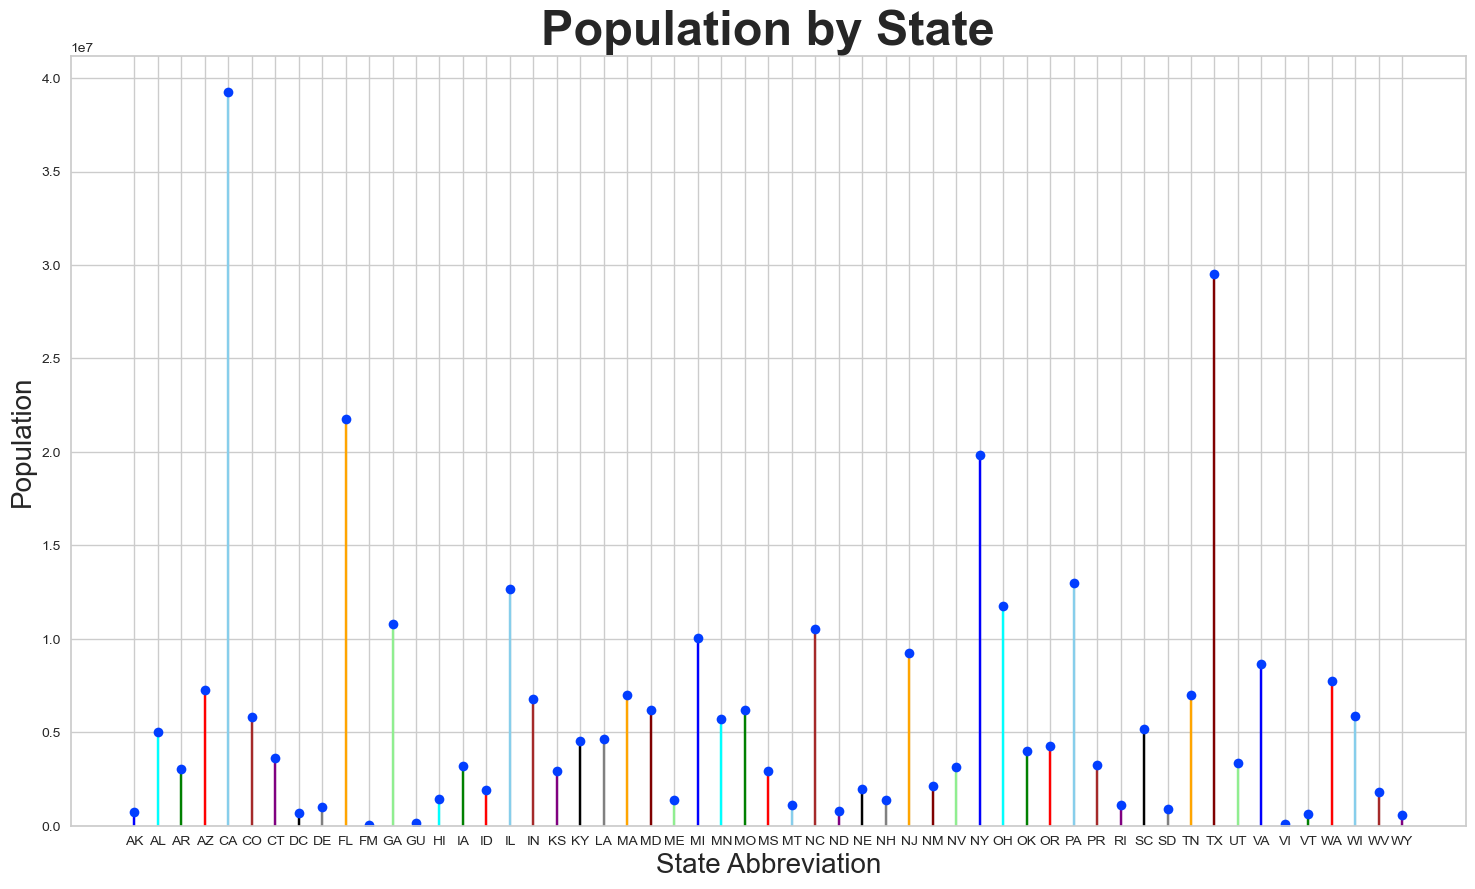

In [16]:
# Lollypop chart for state populations

# creating an empty chart with the figure size
fig, axes = plt.subplots(figsize=(18, 10))

# plotting using plt.vlines
axes.vlines(state_population_df['State'], ymin = 0, 
            ymax = state_population_df['Population'], colors = line_colors)
axes.plot(state_population_df['State'], state_population_df['Population'], "o")

# starting value of y-axis
axes.set_ylim(0)

# details and formatting of chart
plt.title('Population by State', fontsize = 35, weight = 'bold')
plt.xlabel('State Abbreviation', fontsize = 20)
plt.ylabel('Population', fontsize = 20)
plt.xticks(state_population_df['State'])


plt.show()

## Commentary

The states with the largest population are California, Texas, New York, Florida, and Pennsylvania.  The states and territories with the smallest population are Micronesia, Virgin Islands, Guam, the Virgin Islands, Wyoming, and Vermont.  They populations range from a low of 47,29 to a high of 39,237,836 with an average of 3,986,639 per state.

In [17]:
# Print Solvent Bank information

print('States With The Greatest and Least Number of Currently Active Banks')
print('Greatest Number of Active Banks')
active_counts_df.nlargest(10,'Counts')

States With The Greatest and Least Number of Currently Active Banks
Greatest Number of Active Banks


,State,Counts
46,TX,387
16,IL,373
25,MN,255
14,IA,248
18,KS,210
26,MO,210
38,OK,178
37,OH,171
52,WI,166
31,NE,149


In [18]:
# States with least amount of active banks

print('Lowest Number of Active Banks')
active_counts_df.nsmallest(10,'Counts')

Lowest Number of Active Banks


,State,Counts
10,FM,1
49,VI,1
12,GU,3
41,PR,3
7,DC,4
0,AK,5
13,HI,7
42,RI,7
15,ID,11
50,VT,12


In [19]:
# Average number of current banks 

active_cnts = active_counts_df.median()
print('The Average # of Currently Solvent Banks Per State = ', active_cnts)

The Average # of Currently Solvent Banks Per State =  Counts    58.0
dtype: float64


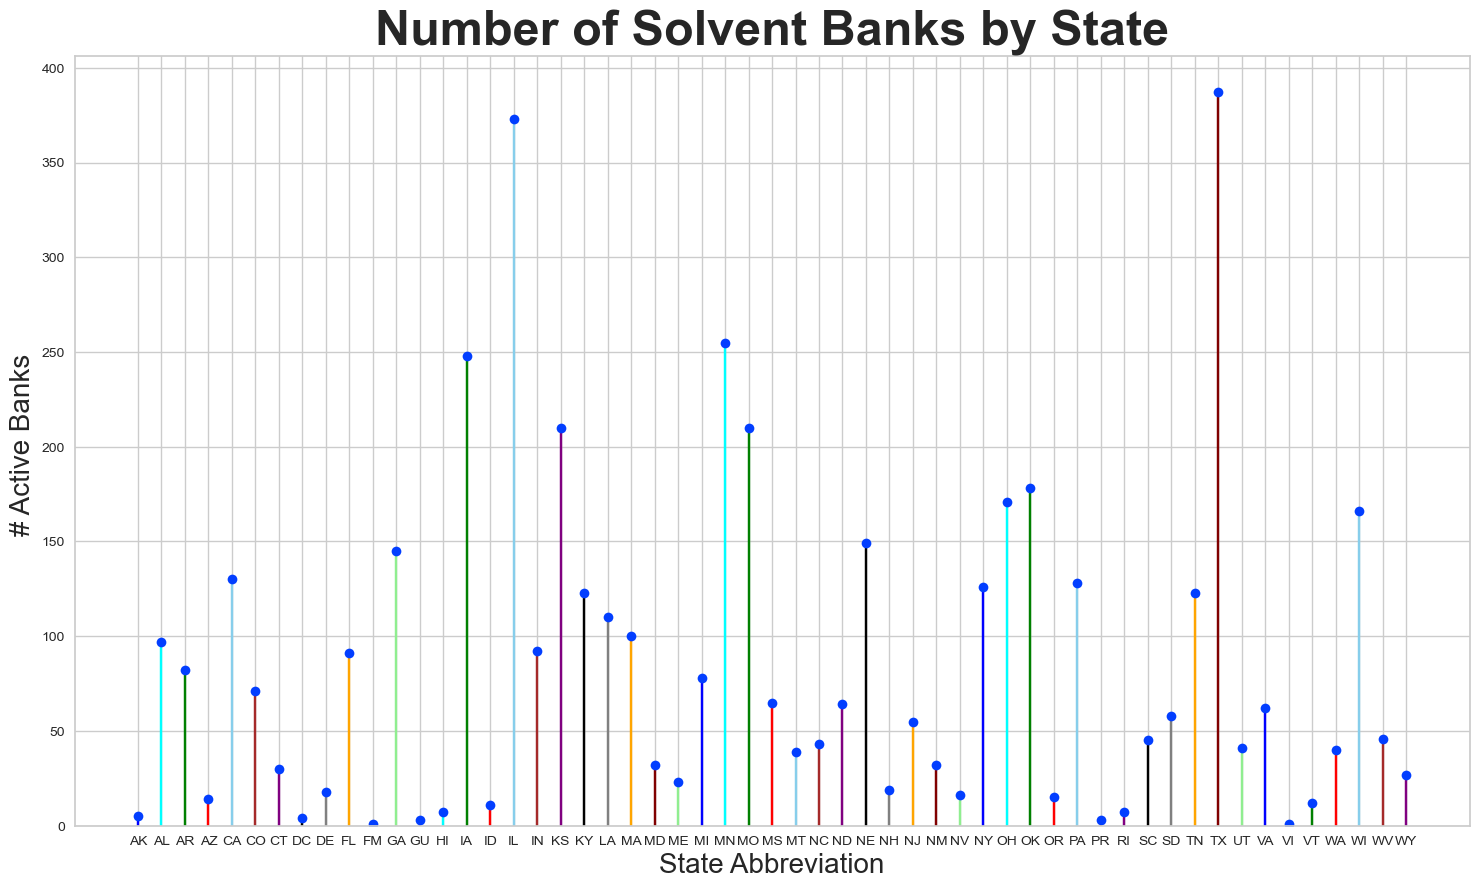

In [20]:
# Lollypop chart for number of active banks by state

# creating an empty chart with the figure size
fig, axes = plt.subplots(figsize=(18, 10))

# plotting using plt.vlines
axes.vlines(active_counts_df['State'], ymin = 0, 
            ymax = active_counts_df['Counts'], colors = line_colors)
axes.plot(active_counts_df['State'], active_counts_df['Counts'], "o")

# starting value of y-axis
axes.set_ylim(0)

# details and formatting of chart
plt.title('Number of Solvent Banks by State', fontsize = 35, weight = 'bold')
plt.xlabel('State Abbreviation', fontsize = 20)
plt.ylabel('# Active Banks ', fontsize = 20)
plt.xticks(active_counts_df['State'])


plt.show()

## Commentary

The states with the most solvent banks are Texas, Illinois, Minnesota, Iowa, Kansas, and Missouri.  The states and territories with the least banks are Washington D.C., Puerto Rico, Guam, the Virgin Islands, and Micronesia.  They number of banks range from a low of 1 to a high of 387 with an average of 58 banks per state.

In [21]:
# States with most amount of failed banks

print('States With The Greatest and Least Number of Bank Failures')
print('States With The Most Failed Banks')
failure_counts_df.nlargest(10,'Counts')

States With The Greatest and Least Number of Bank Failures
States With The Most Failed Banks


,State,Counts
44,TX,697
4,CA,232
9,FL,173
14,IL,162
36,OK,158
18,LA,139
10,GA,118
16,KS,102
5,CO,94
24,MO,72


In [22]:
# States with least amount of failed banks

print('States With The Smallest Number Failed Banks')
failure_counts_df.nsmallest(10,'Counts')

States With The Smallest Number Failed Banks


,State,Counts
47,VI,1
48,VT,2
8,DE,3
13,ID,3
11,HI,4
21,ME,4
7,DC,5
40,RI,5
0,AK,10
26,MT,11


In [23]:
# Average number of failures 

failure_cnts = failure_counts_df.median()
print('The Average Number of Failed Banks Per State = ', failure_cnts)

The Average Number of Failed Banks Per State =  Counts    27.0
dtype: float64


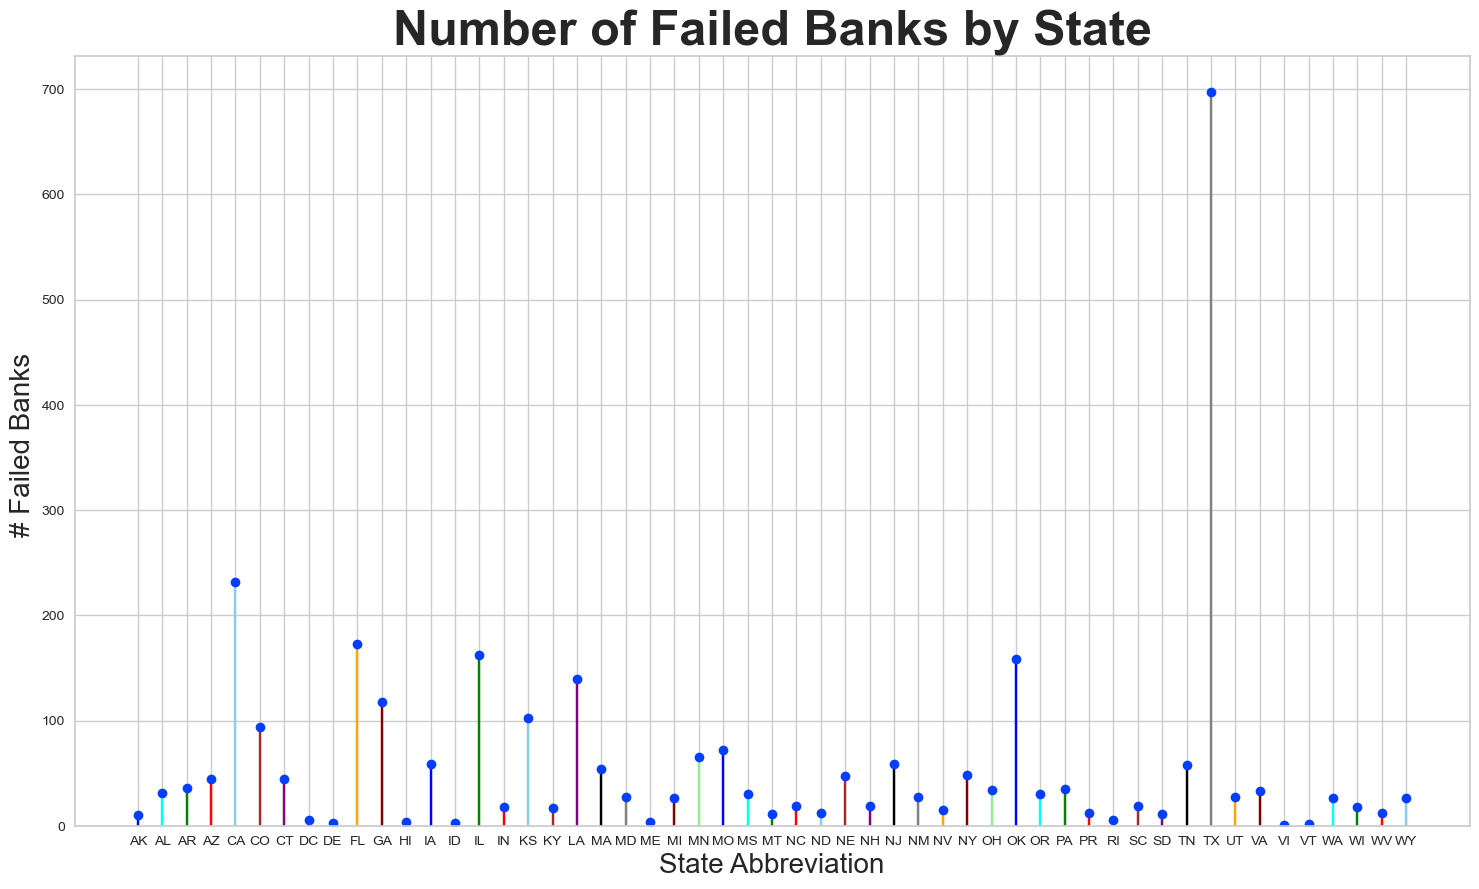

In [24]:
# Lollypop chart for number of bank failures by state

# creating an empty chart with the figure size
fig, axes = plt.subplots(figsize=(18, 10))

# plotting using plt.vlines
axes.vlines(failure_counts_df['State'], ymin = 0, 
            ymax = failure_counts_df['Counts'], colors = line_colors)
axes.plot(failure_counts_df['State'], failure_counts_df['Counts'], "o")

# starting value of y-axis
axes.set_ylim(0)

# details and formatting of chart
plt.title('Number of Failed Banks by State', fontsize = 35, weight = 'bold')
plt.xlabel('State Abbreviation', fontsize = 20)
plt.ylabel('# Failed Banks ', fontsize = 20)
plt.xticks(failure_counts_df['State'])

plt.show()

## Commentary

The states with the most failed banks are Texas, California, Florida, Illinois, and Oklahoma.  The states and territories with the least failed banks are Hawaii, Idaho, Delaware, Vermont, and Virgin Islands.  They number of banks per state range from a low of 1 to a high of 697.  The average is 27 banks per state.  

## Conclusion

Most financial institutions are Commercial banks with deposits less than \\$10 billion.  These local banks are responsible for 66% of the bank failures since 1960.  Savings & Loans also have deposits of less than \\$10 billion and account for most of the remaining 33%.  Because of the FDIC regulation, most of today's banks are solvent, with an average asset-to-deposit percentage of 75%, giving plenty of room for growth while ensuring that deposits are covered.  One would think states with the largest populations would have the most banks and failures.  Yet, except for Texas, there is no visible chain between population, the number of current banks, and the number of past failures. 

Historically most states allowed national banks to operate within their borders, facilitating a smoother economy and commerce between states.  Texas law banned out-of-state banks from operating within the states.  This situation changed during the oil embargo of the 1980s when the price of oil dropped 79%, and the state banks went bankrupt and were sold to out-of-state investors.  Another misconception is that states with the largest populations have a greater number of banks.  Still, Missouri, for example, has a considerably lower population but is five on the list of states with the most banks.

In future Milestones, we will explore if someone can identify banks that could fail using information publicly available online.

# Term Project Milestone 2

In [25]:
# Read in xref file, delete existing output file, 
# and print 1st 10 rows

# Read in the Code Xref file and print the 1st 10 rows.
xref_df = pd.read_excel("code_info.xlsx")

# Delete the existing output file.
file = 'FDIC Milestone 2.xlsx'
location = "C:/DSC550_Data/"
path = os.path.join(location, file)
 
# Remove the file
try:
    os.remove(path)
    
except:
    print('No Prior File Deleted')

print('1st 10 Rows')
xref_df.head(10)

1st 10 Rows


,code,info,code_num,info_type
0,COMMERCIAL,COMMERCIAL,1,bank class
1,FOREIGN,FOREIGN,2,bank class
2,SAVINGS,SAVINGS,3,bank class
3,OTHER,OTHER,4,bank class
4,NATIONAL,NATIONAL,1,bank type
5,REGIONAL,REGIONAL,2,bank type
6,COMMUNITY,COMMUNITY,3,bank type
7,ACTIVE,ACTIVE,1,status
8,FAILURE,FAILURE,2,status
9,AK,Alaska,2,state code


## Fill in the missing data.

In [26]:
# Check for missing data

fdic_info_df.isna().sum()

ID                   45
Institution_Name      0
City                  0
State                 0
Class                 0
Total_Assets          0
Total_Deposits        0
Asset_Deposit_PCT     0
Population            0
Remaining_PCT         0
Bank_Type             0
Minimum_PCT           0
Status                0
dtype: int64

### Replace Nulls/Nan in ID with a Sequential Number.  

Older records are missing an Certification or ID number.  These need to be filled so the original records can be referenced in the future.

#### 5.  Deal With Missing Data
Replace the missing ID numbers with a sequencial number

In [27]:
# Create a loop to fill in the missing IDs.

# Max ID number
max_id = fdic_info_df['ID'].max()
fdic_info_df['ID'].fillna(0, inplace=True)

# Loop thru the ID column and fill in the Nulls/NaNs
for index, row in fdic_info_df.iterrows():
    if row['ID'] == 0.0:
        max_id = max_id + 1
        fdic_info_df.loc[index,['ID']] = max_id

In [28]:
# Check for missing data

fdic_info_df.isna().sum()

ID                   0
Institution_Name     0
City                 0
State                0
Class                0
Total_Assets         0
Total_Deposits       0
Asset_Deposit_PCT    0
Population           0
Remaining_PCT        0
Bank_Type            0
Minimum_PCT          0
Status               0
dtype: int64

In [29]:
# Save original FDIC data for future reference

fdic_info_df_orig = fdic_info_df.copy()

## Add State Number Column Using State Abbreviation

The state where an institution is located is important category, but for modeling there needs to be a number representation.  Creating dummy columns for state would create 50+ additional columns.

#### 2.  Using Feature Extraction/Selection
The records are broken into Active/Failure subsets and then put back together after these failure records are removed.
#### 4.  Adding New Features
Add a new numeric column for State Abbreviation.  

In [30]:
# Create a state xref and convert State into a numeric column

# Create State Xref Dataframe
state_xref_df = xref_df[xref_df['info_type'] == 'state code']
state_xref_df = state_xref_df[['code','code_num']]
state_header = {'code': 'State'}
state_xref_df.rename(columns = state_header, inplace = True)

cols = ['code_num']
# Convert state code to a number
fdic_info_df['State_Nbr'] = fdic_info_df.merge(state_xref_df, how='left', on = 'State')[cols]\
              .rename(columns=lambda x: x.split('_')[0]).fillna(fdic_info_df)

fdic_info_df.head(10)

,ID,Institution_Name,City,State,Class,Total_Assets,Total_Deposits,Asset_Deposit_PCT,Population,Remaining_PCT,Bank_Type,Minimum_PCT,Status,State_Nbr
0,10967.0,"F & M COMMUNITY BANK, NATIONAL ASSOCIATION",PRESTON,MN,COMMERCIAL,194856,174679,89.65,5707390,10.35,COMMUNITY,8,ACTIVE,27
1,10969.0,RANDALL STATE BANK,RANDALL,MN,COMMERCIAL,55767,50382,90.34,5707390,9.66,COMMUNITY,8,ACTIVE,27
2,10970.0,FARMERS STATE BANK OF ROUND LAKE,ROUND LAKE,MN,COMMERCIAL,23210,20903,90.06,5707390,9.94,COMMUNITY,8,FAILURE,27
3,10971.0,PRIME SECURITY BANK,KARLSTAD,MN,COMMERCIAL,128315,105413,82.15,5707390,17.85,COMMUNITY,8,ACTIVE,27
4,10973.0,ALLIANCE BANK,LAKE CITY,MN,COMMERCIAL,769254,624890,81.23,5707390,18.77,COMMUNITY,8,ACTIVE,27
5,10976.0,CENTER NATIONAL BANK,LITCHFIELD,MN,COMMERCIAL,263050,241218,91.70,5707390,8.30,COMMUNITY,8,ACTIVE,27
6,10980.0,ESB BANK,CALEDONIA,MN,COMMERCIAL,152114,128101,84.21,5707390,15.79,COMMUNITY,8,ACTIVE,27
7,10982.0,SECURITY STATE BANK OF OKLEE,OKLEE,MN,COMMERCIAL,40570,34604,85.29,5707390,14.71,COMMUNITY,8,ACTIVE,27
8,10984.0,SECURITY BANK MINNESOTA,ALBERT LEA,MN,COMMERCIAL,148293,128166,86.43,5707390,13.57,COMMUNITY,8,ACTIVE,27
9,10985.0,TOWN & COUNTRY BANK OF ALMELUND,ALMELUND,MN,COMMERCIAL,25942,26667,102.79,5707390,-2.79,COMMUNITY,8,FAILURE,27


## Remove Institution Name, City, and State columns.  

The Institution Name and City columns cannot be converted to a numeric value and there are too many values to create dummy columns from.  The State column was converted to numeric from the code_info dataset.  The ID column will get us back to the original information. 

#### 1.  Dropping Features That Are Not Useful
State has been replaced With State_Nbr and the bank name and city are not necessary for this model.

In [31]:
# Drop Bank Name, City and State columns

fdic_info_df = fdic_info_df.drop(['City','Institution_Name','State'], axis=1)
fdic_info_df.head(10)

,ID,Class,Total_Assets,Total_Deposits,Asset_Deposit_PCT,Population,Remaining_PCT,Bank_Type,Minimum_PCT,Status,State_Nbr
0,10967.0,COMMERCIAL,194856,174679,89.65,5707390,10.35,COMMUNITY,8,ACTIVE,27
1,10969.0,COMMERCIAL,55767,50382,90.34,5707390,9.66,COMMUNITY,8,ACTIVE,27
2,10970.0,COMMERCIAL,23210,20903,90.06,5707390,9.94,COMMUNITY,8,FAILURE,27
3,10971.0,COMMERCIAL,128315,105413,82.15,5707390,17.85,COMMUNITY,8,ACTIVE,27
4,10973.0,COMMERCIAL,769254,624890,81.23,5707390,18.77,COMMUNITY,8,ACTIVE,27
5,10976.0,COMMERCIAL,263050,241218,91.70,5707390,8.30,COMMUNITY,8,ACTIVE,27
6,10980.0,COMMERCIAL,152114,128101,84.21,5707390,15.79,COMMUNITY,8,ACTIVE,27
7,10982.0,COMMERCIAL,40570,34604,85.29,5707390,14.71,COMMUNITY,8,ACTIVE,27
8,10984.0,COMMERCIAL,148293,128166,86.43,5707390,13.57,COMMUNITY,8,ACTIVE,27
9,10985.0,COMMERCIAL,25942,26667,102.79,5707390,-2.79,COMMUNITY,8,FAILURE,27


## Remove Outliers and Standardize the data.

### Look at Both Solvent and Failed Banks for Outliers and Inconsistant Information

In [32]:
# Describe the bank information using status

print('Before Standardization and Outlier Removal')
fdic_info_df.groupby('Status')['Asset_Deposit_PCT'].describe()

Before Standardization and Outlier Removal


,count,mean,std,min,25%,50%,75%,max
Status,,,,,,,,
ACTIVE,4681.0,84.618231,10.047432,0.07,82.07,86.84,89.9800,101.23
FAILURE,3078.0,95.192937,15.283515,0.00,89.62,95.42,99.6675,234.35


### Commentary

The maximum asset to deposit percentage for failed bank is 234%, meaning that there are 134% more deposits than available assets.  Having a minimum of 0 for any bank means there are virtually no deposits.  

### Standardize the Assets to Deposit and Remaing Percentages for Failed Banks

If the asset to deposit percentage > 120%, change the Asset_Deposit_PCT to 120 and the Remaining_PCT -20.  It is more important to acknowledge that a bank failed with no assets to cover the deposits than how much upside down a bank is.  

#### 3,  Tranforming Features
Instead of deleting the high end outliers jthe numbers were capped at 120 to be inline with the actual information.

In [33]:
fdic_info_df['Asset_Deposit_PCT'] = np.where((fdic_info_df['Status'] == 'FAILURE') & (
    fdic_info_df['Asset_Deposit_PCT'] > 120), 120, fdic_info_df['Asset_Deposit_PCT'])

fdic_info_df['Remaining_PCT'] = np.where((fdic_info_df['Status'] == 'FAILURE') & (
    fdic_info_df['Remaining_PCT'] < -20), -20, fdic_info_df['Remaining_PCT'])
                                              
fdic_info_df.head(10)

,ID,Class,Total_Assets,Total_Deposits,Asset_Deposit_PCT,Population,Remaining_PCT,Bank_Type,Minimum_PCT,Status,State_Nbr
0,10967.0,COMMERCIAL,194856,174679,89.65,5707390,10.35,COMMUNITY,8,ACTIVE,27
1,10969.0,COMMERCIAL,55767,50382,90.34,5707390,9.66,COMMUNITY,8,ACTIVE,27
2,10970.0,COMMERCIAL,23210,20903,90.06,5707390,9.94,COMMUNITY,8,FAILURE,27
3,10971.0,COMMERCIAL,128315,105413,82.15,5707390,17.85,COMMUNITY,8,ACTIVE,27
4,10973.0,COMMERCIAL,769254,624890,81.23,5707390,18.77,COMMUNITY,8,ACTIVE,27
5,10976.0,COMMERCIAL,263050,241218,91.70,5707390,8.30,COMMUNITY,8,ACTIVE,27
6,10980.0,COMMERCIAL,152114,128101,84.21,5707390,15.79,COMMUNITY,8,ACTIVE,27
7,10982.0,COMMERCIAL,40570,34604,85.29,5707390,14.71,COMMUNITY,8,ACTIVE,27
8,10984.0,COMMERCIAL,148293,128166,86.43,5707390,13.57,COMMUNITY,8,ACTIVE,27
9,10985.0,COMMERCIAL,25942,26667,102.79,5707390,-2.79,COMMUNITY,8,FAILURE,27


In [34]:
# Will changing the high outliers make a difference

print('After Failure High Outliers Standardization')
fdic_info_df.groupby('Status')['Asset_Deposit_PCT'].describe()

After Failure High Outliers Standardization


,count,mean,std,min,25%,50%,75%,max
Status,,,,,,,,
ACTIVE,4681.0,84.618231,10.047432,0.07,82.07,86.84,89.9800,101.23
FAILURE,3078.0,94.246137,11.537075,0.00,89.62,95.42,99.6675,120.00


### Commentary

Lowering the maximum for failures doesn't change the various percentiles, but does change the mean by less than 1 point.

### Remove Records That Fall in the Lower 10% of Assets to Deposits % for Failed Banks

For these failures if there were plenty of assets to cover the deposits so how could they fail.  These should be considered outliers.

#### 1.  Dropping Rows That Could Not Be True.
If deposits were 80% or less than assets then these banks could have covered the deposits and the bank not fail.

In [35]:
# Remove the lower 10% of assets to deposits % for both Active and Failed banks

#Split the banks into active and failed dataframes
active_df2 = fdic_info_df[fdic_info_df['Status'] == 'ACTIVE']
failure_df2 = fdic_info_df[fdic_info_df['Status'] == 'FAILURE']

# Identify the records in the lower 10% of assets to deposits %
failure_df2['Decile'] = pd.qcut(failure_df2['Asset_Deposit_PCT'], 10, labels=False)

# Drop the failure records in the lower 10%
failure_df2 = failure_df2[failure_df2.Decile != 0]
failure_df2 = failure_df2.drop(['Decile'], axis=1)

# Put the bank records back together.
fdic_info_df2 = pd.concat([active_df2,failure_df2])

# Look at the changes in percentiles
print('After Failure Lower Outliers Removal')
fdic_info_df2.groupby('Status')['Asset_Deposit_PCT'].describe()

After Failure Lower Outliers Removal


,count,mean,std,min,25%,50%,75%,max
Status,,,,,,,,
ACTIVE,4681.0,84.618231,10.047432,0.07,82.0700,86.84,89.9800,101.23
FAILURE,2770.0,96.821830,8.042432,81.05,91.8925,96.38,100.1975,120.00


### Commentary

Removing the bottom 10% of failure records of assets to deposits, changed all the statistics.  They are more inline with what would be expected for failed banks.  The older data was missing some key pieces of information.

## Create Dummy Records for Status, Bank Class, and Bank Type.

These are the main categorical columns.  These 9 columns along with state_nbr will be used in decision.

#### 6.  Create Dummy Variables
Creating Dummy records will give even weight to Status, Bank Class, and Bank Type.

In [36]:
# Get Categorical Columns and Create Dummy Columns

# Get the categorical columns
object_cols = fdic_info_df2.select_dtypes("object").columns
object_cols = list(set(object_cols))
# Create dummy records
fdic_dummy_df = pd.get_dummies(fdic_info_df2, columns = object_cols)

fdic_dummy_df.head(10)

,ID,Total_Assets,Total_Deposits,Asset_Deposit_PCT,Population,Remaining_PCT,Minimum_PCT,State_Nbr,Bank_Type_COMMUNITY,Bank_Type_NATIONAL,Bank_Type_REGIONAL,Class_COMMERCIAL,Class_FOREIGN,Class_OTHER,Class_SAVINGS,Status_ACTIVE,Status_FAILURE
0,10967.0,194856,174679,89.65,5707390,10.35,8,27,1,0,0,1,0,0,0,1,0
1,10969.0,55767,50382,90.34,5707390,9.66,8,27,1,0,0,1,0,0,0,1,0
3,10971.0,128315,105413,82.15,5707390,17.85,8,27,1,0,0,1,0,0,0,1,0
4,10973.0,769254,624890,81.23,5707390,18.77,8,27,1,0,0,1,0,0,0,1,0
5,10976.0,263050,241218,91.70,5707390,8.30,8,27,1,0,0,1,0,0,0,1,0
6,10980.0,152114,128101,84.21,5707390,15.79,8,27,1,0,0,1,0,0,0,1,0
7,10982.0,40570,34604,85.29,5707390,14.71,8,27,1,0,0,1,0,0,0,1,0
8,10984.0,148293,128166,86.43,5707390,13.57,8,27,1,0,0,1,0,0,0,1,0
10,10987.0,88944,81914,92.10,5707390,7.90,8,27,1,0,0,1,0,0,0,1,0
11,10988.0,2721777,2101375,77.21,5707390,22.79,8,27,1,0,0,1,0,0,0,1,0


In [37]:
# Save final result records

fdic_dummy_df.to_excel("C:/DSC550_Data/FDIC Milestone 2.xlsx", sheet_name='FDIC') 

### Note - Based on comments from grading Milestone 2, the ID and State Number will be removed and the Dummy DataFrame will be recreated.

In [38]:
# Convert the Status into a number
# Drop ID and State Number columns

# Status:  1 for Active, 0 for Failure
fdic_info_df2['Status_Nbr'] = fdic_info_df2['Status'].replace(to_replace = ['ACTIVE','FAILURE'], value=[1,0])

fdic_info_df2 = fdic_info_df2.drop(['ID','State_Nbr'], axis=1)
fdic_info_df2.head(10)

,Class,Total_Assets,Total_Deposits,Asset_Deposit_PCT,Population,Remaining_PCT,Bank_Type,Minimum_PCT,Status,Status_Nbr
0,COMMERCIAL,194856,174679,89.65,5707390,10.35,COMMUNITY,8,ACTIVE,1
1,COMMERCIAL,55767,50382,90.34,5707390,9.66,COMMUNITY,8,ACTIVE,1
3,COMMERCIAL,128315,105413,82.15,5707390,17.85,COMMUNITY,8,ACTIVE,1
4,COMMERCIAL,769254,624890,81.23,5707390,18.77,COMMUNITY,8,ACTIVE,1
5,COMMERCIAL,263050,241218,91.70,5707390,8.30,COMMUNITY,8,ACTIVE,1
6,COMMERCIAL,152114,128101,84.21,5707390,15.79,COMMUNITY,8,ACTIVE,1
7,COMMERCIAL,40570,34604,85.29,5707390,14.71,COMMUNITY,8,ACTIVE,1
8,COMMERCIAL,148293,128166,86.43,5707390,13.57,COMMUNITY,8,ACTIVE,1
10,COMMERCIAL,88944,81914,92.10,5707390,7.90,COMMUNITY,8,ACTIVE,1
11,COMMERCIAL,2721777,2101375,77.21,5707390,22.79,COMMUNITY,8,ACTIVE,1


In [39]:
# Recreate the Dummy DataFrame
# Get Categorical Columns and Create Dummy Columns

# Get the categorical columns
object_cols = fdic_info_df2.select_dtypes("object").columns
object_cols = list(set(object_cols))
# Create dummy records
fdic_dummy_df = pd.get_dummies(fdic_info_df2, columns = object_cols)

fdic_dummy_df.head(10)

,Total_Assets,Total_Deposits,Asset_Deposit_PCT,Population,Remaining_PCT,Minimum_PCT,Status_Nbr,Bank_Type_COMMUNITY,Bank_Type_NATIONAL,Bank_Type_REGIONAL,Class_COMMERCIAL,Class_FOREIGN,Class_OTHER,Class_SAVINGS,Status_ACTIVE,Status_FAILURE
0,194856,174679,89.65,5707390,10.35,8,1,1,0,0,1,0,0,0,1,0
1,55767,50382,90.34,5707390,9.66,8,1,1,0,0,1,0,0,0,1,0
3,128315,105413,82.15,5707390,17.85,8,1,1,0,0,1,0,0,0,1,0
4,769254,624890,81.23,5707390,18.77,8,1,1,0,0,1,0,0,0,1,0
5,263050,241218,91.70,5707390,8.30,8,1,1,0,0,1,0,0,0,1,0
6,152114,128101,84.21,5707390,15.79,8,1,1,0,0,1,0,0,0,1,0
7,40570,34604,85.29,5707390,14.71,8,1,1,0,0,1,0,0,0,1,0
8,148293,128166,86.43,5707390,13.57,8,1,1,0,0,1,0,0,0,1,0
10,88944,81914,92.10,5707390,7.90,8,1,1,0,0,1,0,0,0,1,0
11,2721777,2101375,77.21,5707390,22.79,8,1,1,0,0,1,0,0,0,1,0


In [40]:
# Describe before and after creating 
# the Dummy DataFrame

print('Number of Original Rows and Columns = ', fdic_info_df2.shape)
print('Number of Rows and Columns in Dummy DataFrame = ', fdic_dummy_df.shape)

Number of Original Rows and Columns =  (7451, 10)
Number of Rows and Columns in Dummy DataFrame =  (7451, 16)


# Term Project Milestone 3

## Choosing The Models

Binary Classification is a supervised learning algorithm that categorizes new observations into classes 0 or 1.  These models predict outcomes as Truly Positive and Negative and Falsely Positive and Negative.  If a bank is shown to be truly solvent (Active), then it should be considered a good place to open an account.  A bank that would truly be a failure (Failure) in the future is not worth the risk, and you should put your money elsewhere.  The false positives and failures (Actives/Failures) are the ones to research why they were mislabeled.

Decision Tree Classifier and Logistic Regression are Binary Algorithms in returning either a positive or negative result.

- Decision Tree Classifier: This model allows for moving through each step of the decision tree until until the final outcome is reached.  In this case, will this be a bank that will remain active and solvent or could this bank fail and the deposit is lost.

- Logistic Regression Model: This model is used to predict the probability that an instance of belonging to a given class or not. In this case whether the bank will remain active or a failure.


## Split the data into a training and test sets, where the “Status_Nbr” column is the target.

In [41]:
# Split fdic data into training and testing data sets

# Copy the fdic dummy dataframe
no_status_df = fdic_dummy_df.copy()

# Delete the Status columns
no_status_df = no_status_df.drop(['Status_Nbr', 'Status_ACTIVE', 'Status_FAILURE'], axis = 1)

# Create Status Target column
status_df = fdic_dummy_df['Status_Nbr']

# Split data into 80/20 sets
x_train, x_test, y_train, y_test = train_test_split(no_status_df, status_df, 
                                                test_size = 0.2, random_state = 1)

print('Number of x_train Rows and Columns = ', x_train.shape)
print('Number of y_train Rows and Columns = ', y_train.shape)
print('Number of x_test Rows and Columns = ', x_test.shape)
print('Number of y_test Rows and Columns = ', y_test.shape)

Number of x_train Rows and Columns =  (5960, 13)
Number of y_train Rows and Columns =  (5960,)
Number of x_test Rows and Columns =  (1491, 13)
Number of y_test Rows and Columns =  (1491,)


## Create Decision Tree Classifier

Decision Trees are one of the Binary Classification Algorithms.  These are used when the results are X or Y.  For example:  Yes or No, Dead or Alive, 0 or 1, or in this case Active or Failure

In [42]:
# Create the Decision Tree Classifier, 
# train the model, and test the results

# Create a Decision Tree object
dtc = DecisionTreeClassifier()

# Train the Decision Tree model
dtc.fit(x_train, y_train)

# Train model to make predictions
y_pred = dtc.predict(x_test)

In [43]:
# Calculate accuracy

ac_score = accuracy_score(y_test, y_pred)
print('The Accuracy Score For Decision Tree Classifier = ', round(100 * ac_score, 2), '%', sep = '')

The Accuracy Score For Decision Tree Classifier = 86.52%


In [44]:
# Double check the accuracy

target_names = ['Failure', 'Active']
class_rpt = classification_report(y_test, y_pred, target_names=target_names)

print('Classification Report For Decision Tree Classifier')
print(class_rpt)

Classification Report For Decision Tree Classifier
              precision    recall  f1-score   support

     Failure       0.82      0.82      0.82       549
      Active       0.89      0.89      0.89       942

    accuracy                           0.87      1491
   macro avg       0.85      0.86      0.86      1491
weighted avg       0.87      0.87      0.87      1491



### Commentary

#### Precision

- Active = .89  
- Failure = .82  

The percentage of correct predictions relative to total correct predictions by class.  The Predictions were more accurate for Active banks.

#### Recall
- Active = .89  
- Failure = .82  

The Percentage of correct predictions relative to total actual Active and Failures.  The Recall was more accurate for Active banks.

#### F1-Score
- Active = .89  
- Failure = .82  

A weighted harmonic mean of precision and recall. The closer to 1, the better the model.  The F1-Score for both Active and Failure approach 1, but Active has a better score.

#### Accuracy
The overall accuracy is .87  

Note - The Classification Report numbers change slightly between each run.

<Figure size 800x550 with 0 Axes>

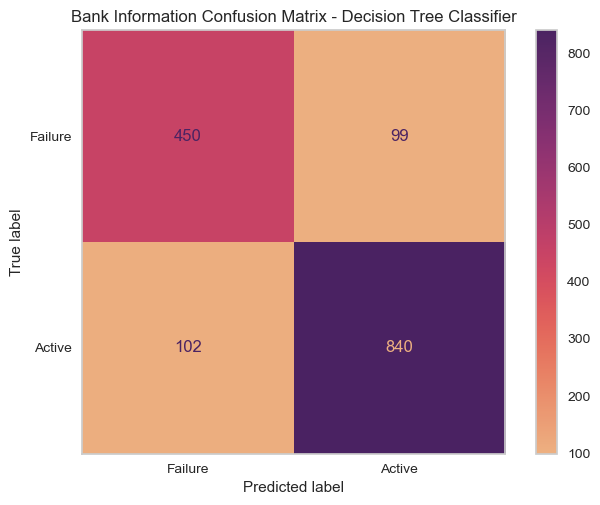

In [45]:
# create and plot a confusion matrix

# Set up labels
labels = ['Failure', 'Active']

# Plot confusion matrix
fig = plt.figure()
plot_confusion_matrix(dtc, x_test, y_test, display_labels = labels, cmap = "flare")
plt.title('Bank Information Confusion Matrix - Decision Tree Classifier')
plt.grid(False)

plt.show()

## Commentary

The Confusion Matrix explains the 86.5% accuracy rate.  There are 1491 test records.  

#### Classified Correctly
- Currently Active Banks = 840  
- Previously Failed Banks = 453  

#### Classified Incorrectly
- Failed Banks Misclassified as Active = 96  
- Active Banks Misclassified as Failures = 102  

A bank that is Active/Active woud be a good place to put my money.  Banks that are listed as either Failure/Failure or misclassified as Active (Failure/Active) are banks that would not be considered because they have failed.  The Active banks misclassified as Failed would require a more detailed review before any money is deposited.  
<br>
Note - The Confusion Matrix numbers change slightly between each run.

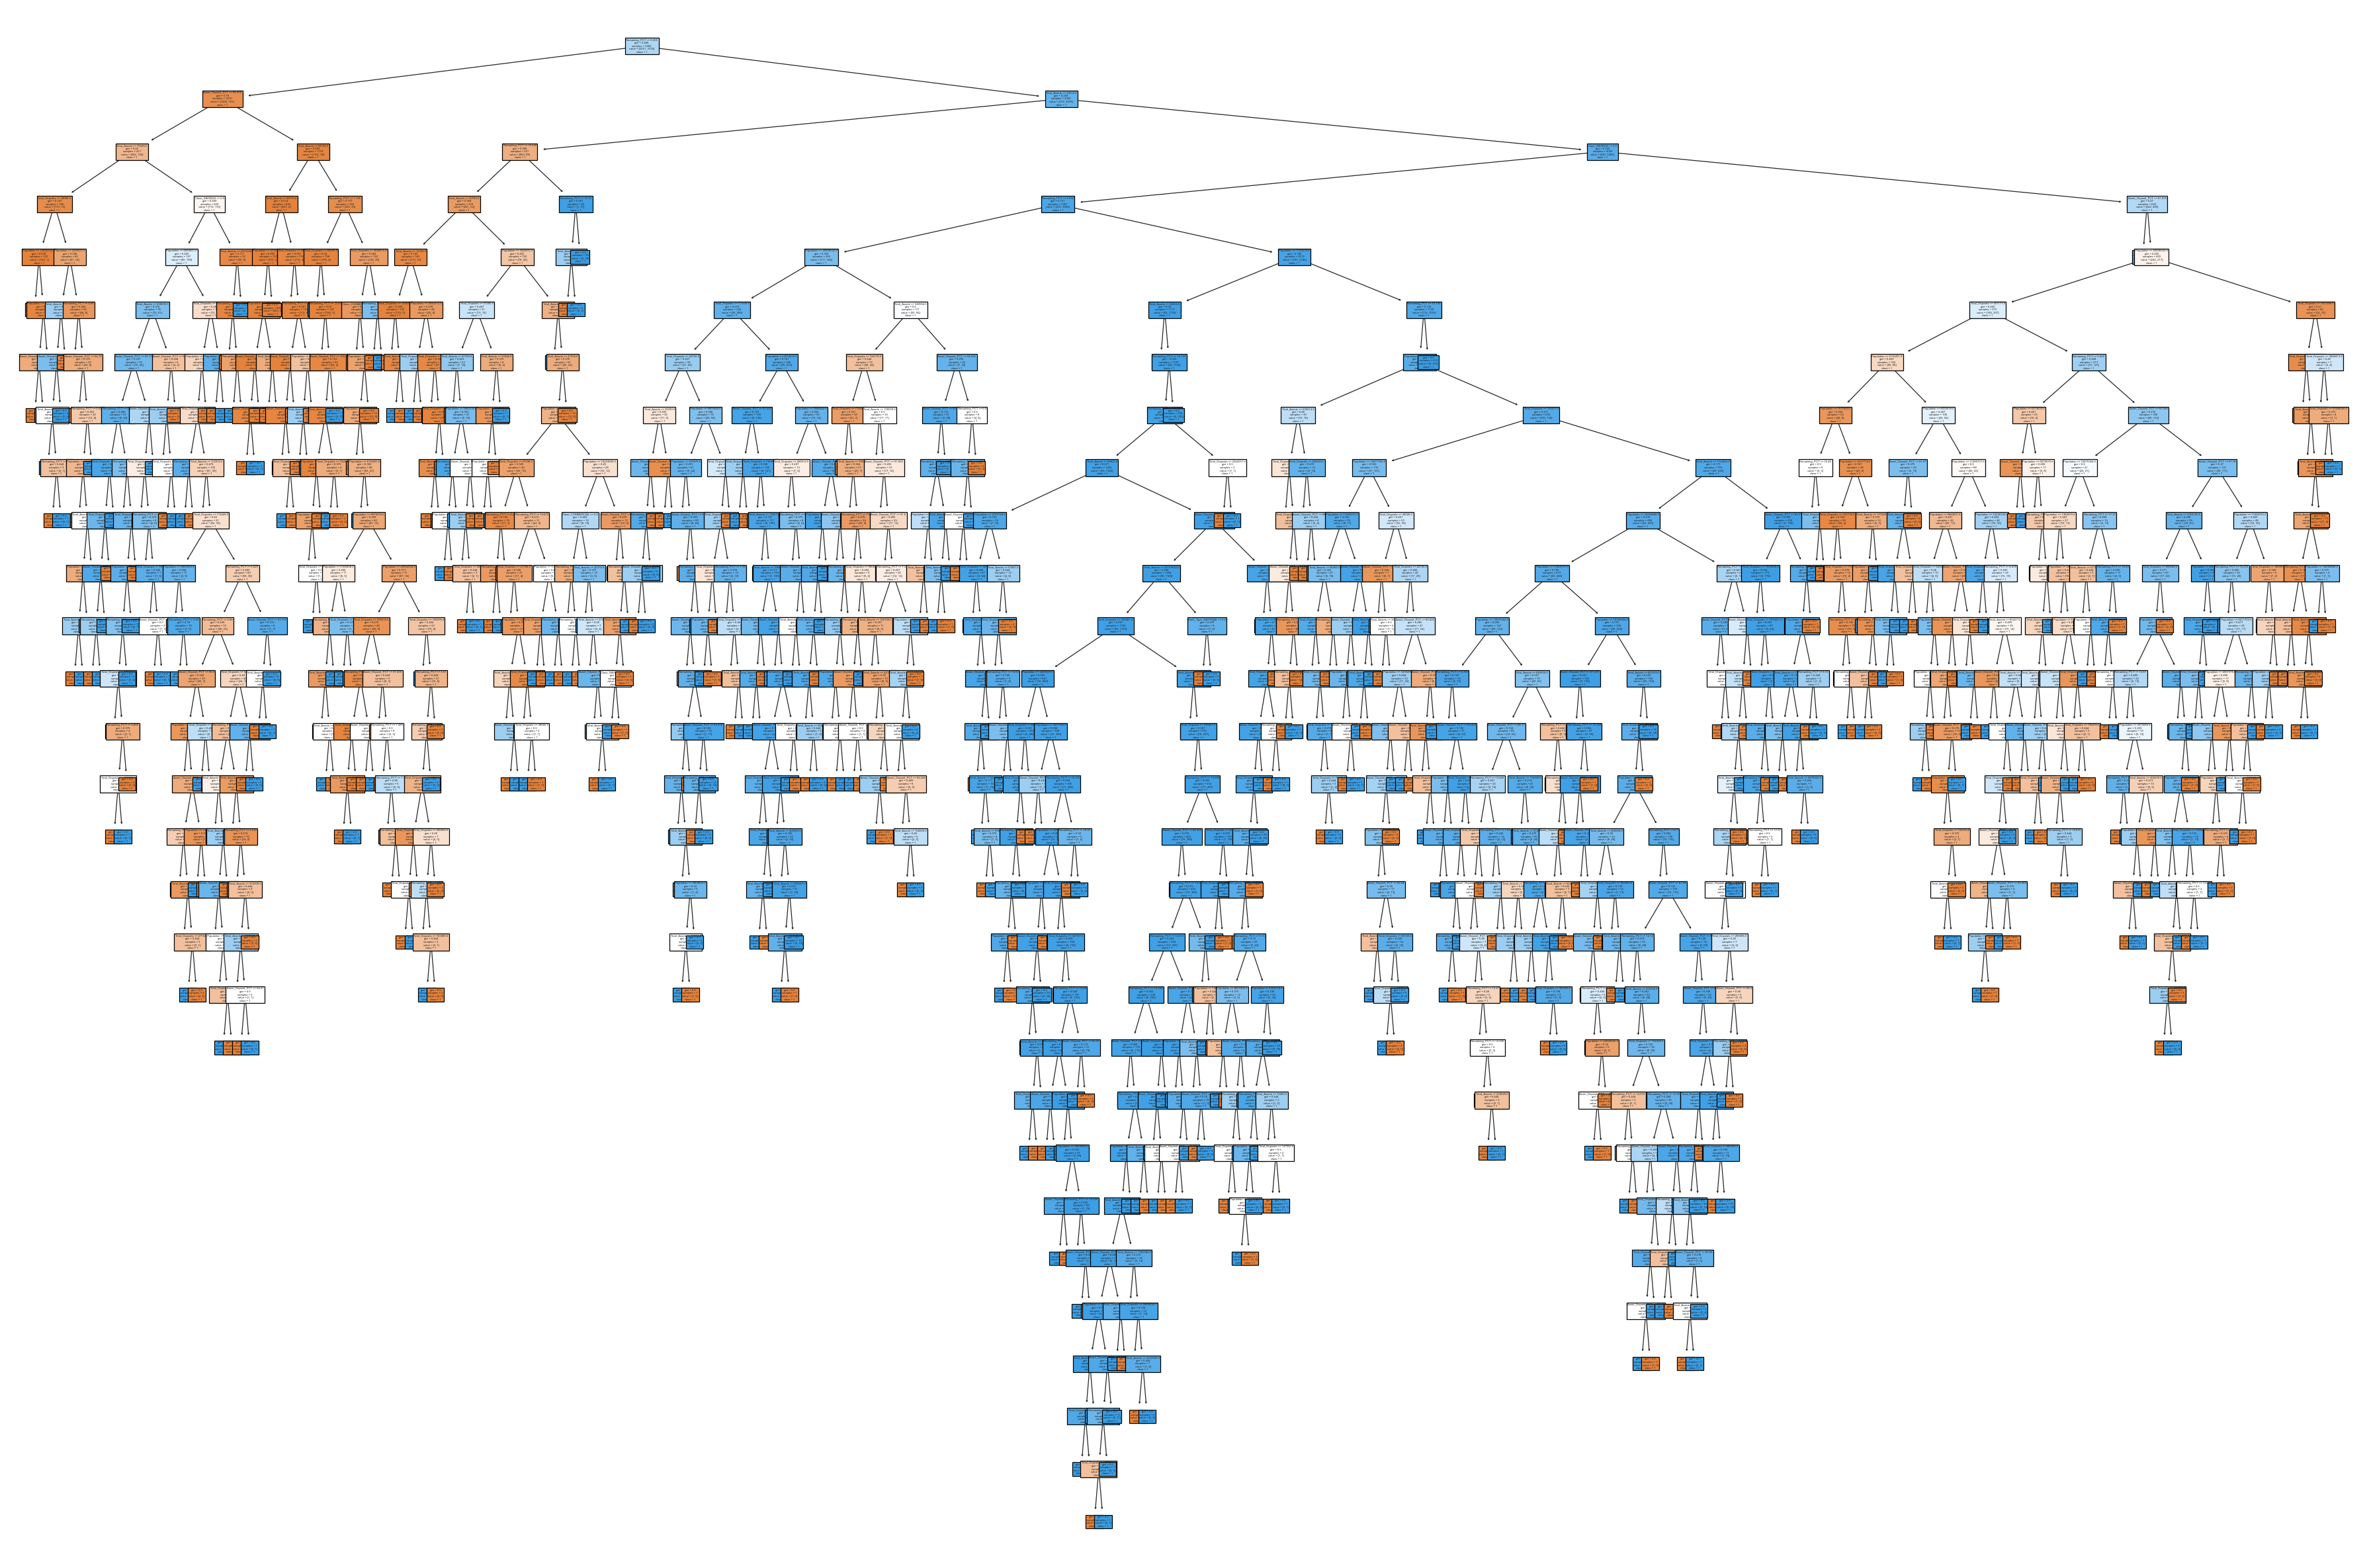

In [46]:
# Create the decision tree graph

# Create a lists of x and y data
feature_names = list(fdic_dummy_df.drop(['Status_Nbr'], axis=1).columns)
target_names = [str(s) for s in fdic_dummy_df.Status_Nbr]

# Set up figure size
fig = plt.subplots(figsize = (15, 10), dpi=300)

# Plot decision tree
tree = tree.plot_tree(dtc, 
                   feature_names = feature_names,  
                   class_names = target_names,
                   filled = True)

### Commentary

This Decision Tree conveys a enormous amount of information and the size makes it impossible to read the results in this notebook.

## Create Logistic Regression Model

Logistic Regression is another Binary Classification Algorithm. These are used when the results are X or Y. For example: Yes or No, Dead or Alive, 0 or 1, or in this case Active or Failure

In [47]:
# Create the Logistic Regression Model,
# train the model, and test the results

# Create logistic regression object
logit = LogisticRegression(solver="liblinear", random_state=0)

# Train the logistic regression model
logit.fit(x_train, y_train)

# Train model to make predictions
y_pred = logit.predict(x_test)

In [48]:
# Calculate accuracy

ac_score = accuracy_score(y_test, y_pred)
print('The Accuracy Score For Logistic Regression = ', round(100 * ac_score, 2), '%', sep = '')

The Accuracy Score For Logistic Regression = 85.18%


In [49]:
# Double check the accuracy

target_names = ['Failure', 'Active']
class_rpt = classification_report(y_test, y_pred, target_names=target_names)

print('Classification Report For Logistic Regression')
print(class_rpt)

Classification Report For Logistic Regression
              precision    recall  f1-score   support

     Failure       0.76      0.87      0.81       549
      Active       0.92      0.84      0.88       942

    accuracy                           0.85      1491
   macro avg       0.84      0.86      0.84      1491
weighted avg       0.86      0.85      0.85      1491



### Commentary

#### Precision

- Active = .92  
- Failure = .76  

The percentage of correct predictions relative to total correct predictions by class.  The Predictions were more accurate for Active banks.

#### Recall
- Active = .84  
- Failure = .87  

The Percentage of correct predictions relative to total actual Active and Failures.  The Recall was more accurate for Failed banks.

#### F1-Score
- Active = .88  
- Failure = .81  

A weighted harmonic mean of precision and recall. The closer to 1, the better the model.  The F1-Score for both Active and Failure approach 1, but Active has a better score.

#### Accuracy
The overall accuracy is .85  

Note - The Classification Report numbers change slightly between each run.

<Figure size 800x550 with 0 Axes>

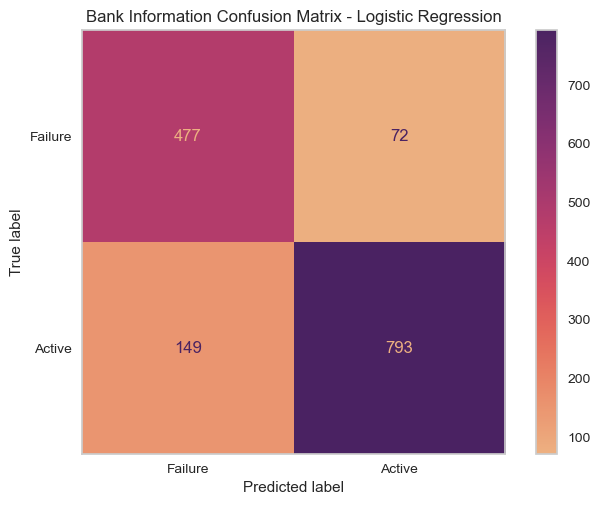

In [50]:
# create and plot a confusion matrix

# Plot confusion matrix using the labels in the Decision Tree
fig = plt.figure()
plot_confusion_matrix(logit, x_test, y_test, display_labels = labels, cmap = "flare")
plt.title('Bank Information Confusion Matrix - Logistic Regression')
plt.grid(False)

plt.show()

### Commentary

The Confusion Matrix explains the 85% accuracy rate.  There are 1491 test records.

#### Classified Correctly
- Currently Active Banks = 793  
- Previously Failed Banks = 477  

#### Classified Incorrectly
- Failed Banks Misclassified as Active = 72  
- Active Banks Misclassified as Failures = 149  

These results are essentially the same as Decision Trees.  A bank that is Active/Active woud be a good place to put my money.  Banks that are listed as either Failure/Failure or misclassified as Active (Failure/Active) are banks that would not be considered because they have failed.  The Active banks misclassified as Failed would require a more detailed review before any money is deposited.  
<br>
Note - The Confusion Matrix numbers change slightly between each run.

0.9000750694511545


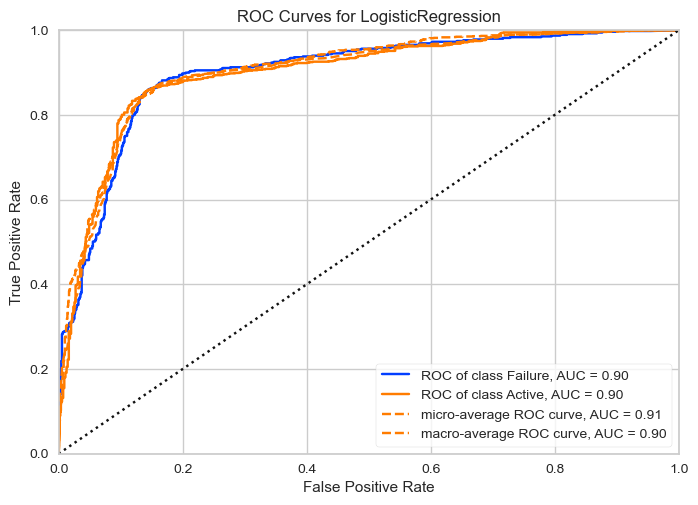

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [51]:
# Create Receiver Operating Characteristic (ROC) with Area Under the Curve (AUC)

# Set up the ROC visualizer
ROC_labels = {0: 'Failure', 1: 'Active'}
roc_curve = ROCAUC(logit, encoder = ROC_labels, solver = 'liblinear')

# Fit the test data
roc_curve.fit(x_test, y_test)

# Display the model on the test data
roc_score = roc_curve.score(x_test, y_test)  
print(roc_score)
roc_curve.show()

### Commentary

The ROC Curve shows these models have are good predictors of bank solvency and failures.  The Area Under the ROC Curve (AUC) shows consistantly a .90 to .91, which is considered excellent.  

## Conclusion

The Accuracy Scores, Classification Reports, and Confusion Matrix for both the Decision Tree and Logistic Regression and the ROC Curve (AUC) reflect consistant prediction statistics.  

- The Accuracy Score is between 85% and 87% as part of the Classification Report or when calculated as a separate Accuracy Score for both the Decision Tree and Logistic Regression Models.  

- The Classification Report Precision and F1-Score favor Active solvent banks for both the Decision Tree and Logistic Regression models.  The Recall score for the Decision Tree points leans toward bank Failure for the Decision Tree, but Active solvent banks have a better Recall score for the Logistic Regression method.   

- The Confusion Matrix results are essentially the same for both the Decision Tree and Logistic Regression models with Accuracy Scores between 85% and 87%. A bank that is Active/Active woud be a good place to put my money. Banks that are listed as either Failure/Failure or misclassified as Active (Failure/Active) are banks that would not be considered because they have failed. The Active banks misclassified as Failed would require a more detailed review before any money is deposited.  

- The ROC Curve indicates the Logistic Regression model is a good predictor of current bank solvency. The Area Under the ROC Curve (AUC) shows consistantly a .90 to .91, which is considered excellent.  

The consistancy between the Decision Tree Classifier and Logistic Regression shows that you would get the same results no matter which model to use when deciding where to open an account.

# Term Project Milestone 4

## Does the Model Work?

Additional test records are created to see if the model preforms as designed.

In [52]:
# Read in the x and y test files and print the contents.

x_test_sample = pd.read_excel("x_test_sample.xlsx")
y_test_sample = pd.read_excel("y_test_sample.xlsx")

print('x test sample records')
x_test_sample

x test sample records


,Total_Assets,Total_Deposits,Asset_Deposit_PCT,Population,Remaining_PCT,Minimum_PCT,Bank_Type_COMMUNITY,Bank_Type_NATIONAL,Bank_Type_REGIONAL,Class_COMMERCIAL,Class_FOREIGN,Class_OTHER,Class_SAVINGS
0,131856,98219,74.49,29527941,25.51,8,1,0,0,1,0,0,0
1,27787,26957,97.01,29527941,2.99,8,1,0,0,1,0,0,0
2,216989,325050,120.00,29527941,-20.00,8,1,0,0,1,0,0,0
3,85485,77140,90.24,29527941,9.76,8,1,0,0,1,0,0,0


In [53]:
print('y test sample records')
y_test_sample

y test sample records


,Status_Nbr
0,1
1,1
2,0
3,0


### Commentary

The files contain 4 records:  2 Active and 2 Failures.  Of the active bank records, one has a 75% asset to deposit ratio showing the current deposits are funded, the other has a 97% asset to deposit ratio and should be given a second look.  Of the banks that failed, one had an asset to deposit ratio of 120% and truly failed, the other record also failed, but only had an asset to deposit ratio of 90%.  All the banks are Community Commercial banks.

<Figure size 800x550 with 0 Axes>

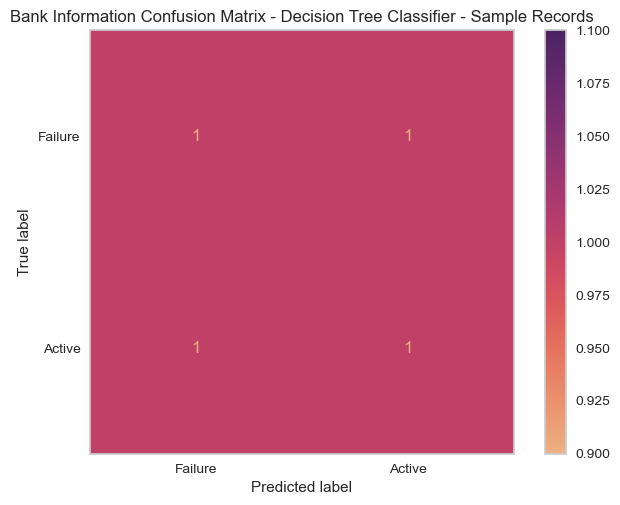

In [54]:
# Recreate and plot a confusion matrix for 
# the Decision Tree for sample records

# Set up labels
labels = ['Failure', 'Active']

# Plot confusion matrix
fig = plt.figure()
plot_confusion_matrix(dtc, x_test_sample, y_test_sample, 
                      display_labels = labels, cmap = "flare")
plt.title('Bank Information Confusion Matrix - Decision Tree Classifier - Sample Records')
plt.grid(False) 

plt.show()

### Commentary

For every run of the Decision Tree Classifier, there is only 1 truly active bank and 1 false failure.  Of the failed banks, either both are failures or 1 is a true failure and 1 is false active.

Note - The Confusion Matrix numbers change slightly between each run.

<Figure size 800x550 with 0 Axes>

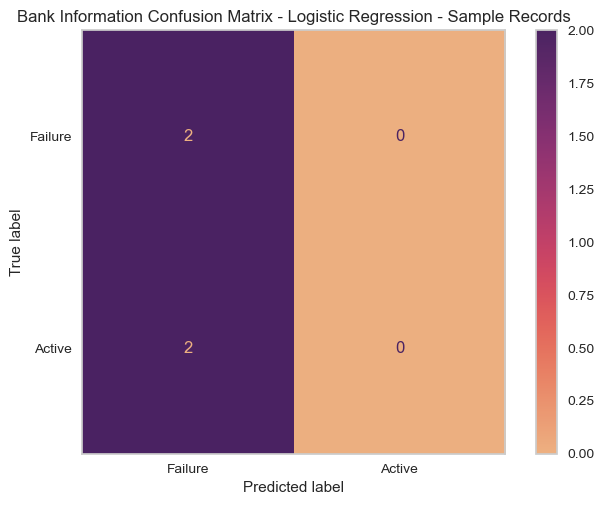

In [55]:
# Recreate and plot a confusion matrix for 
# Logistic Regression for sample records

# Set up labels
labels = ['Failure', 'Active']

# Plot confusion matrix
fig = plt.figure()
plot_confusion_matrix(logit, x_test_sample, y_test_sample, 
                      display_labels = labels, cmap = "flare")
plt.title('Bank Information Confusion Matrix - Logistic Regression - Sample Records')
plt.grid(False) 

plt.show()

### Commentary

For every run of the Linear Regression, only the fact that the banks were active or failed are shown.  The "grey" areas of false actives and failures were not represented.  Not having a false failure for an active bank is a concern because these banks require more research before making a deposit.  Not having a false active for a failed bank is not as important because the bank is no longer in business.

Note - The Confusion Matrix numbers change slightly between each run.

## Conclusion

Both models are excellent at identifying active and failed banks, but the Decision Tree Classifier is better at identifying the false failures of active banks.  These institutions require more research to confirm there is adequate assets to fund the customers deposits.  A false active for a failed bank does not require research in these cases because the bank is no longer in business.

## References

[FDIC - Current Financial & Regulatory Data](https://banks.data.fdic.gov/bankfind-suite/financialreporting?charterClass=ALL&charteringAgency=ALL&commonSearchesExpand=true&establishedDateRangeExpand=true&establishedEndRange=6%2F26%2F2023&establishedStartRange=01%2F01%2F1792&inactiveDateRangeExpand=true&inactiveEndRange=6%2F26%2F2023&inactiveStartRange=01%2F01%2F1970&incomeBasis=YTD&institutionType=banks&limitEstablishedDate=false&limitInactiveDate=false&pageNumber=1&primaryRegulator=ALL&regulatoryExpand=true&reportPeriod=20230331&resultLimit=25&sortField=CERT&sortOrder=ASC&unitType=%24)

[FDIC - Bank Failures & Assistance Data](https://banks.data.fdic.gov/explore/failures/?aggReport=detail&displayFields=NAME%2CCERT%2CFIN%2CCITYST%2CFAILDATE%2CSAVR%2CRESTYPE%2CCOST%2CRESTYPE1%2CCHCLASS1%2CQBFDEP%2CQBFASSET&endFailYear=2023&sortField=FAILDATE&sortOrder=desc&startFailYear=1960)

[Investopedia - Regional Banks](https://www.investopedia.com/what-is-a-regional-bank-7479637)

[Investopedia - Savings & Loan Companies vs. Commercial Banks: What's the Difference?](https://www.investopedia.com/ask/answers/041015/what-difference-between-savings-loan-company-and-bank.asp)

[GlobalBanks - Before a Bank Fails: 12 Signs to Look Out For](https://globalbanks.com/before-a-bank-fails-warning-signs/#warning)

[U.S. Census Bureau, 2021 American Community Survey - Population Estimates](https://data.census.gov/table?q=state+populations&tid=ACSDP1Y2021.DP05&tp=true)

[The Motley Fool - Why Almost Every Big Texas Bank Failed in the 1980s](https://www.fool.com/investing/general/2015/04/22/why-almost-every-big-texas-bank-failed-in-the-1980.aspx)

[U.S. Census Bureau - American National Standards Institute (ANSI) Codes for States](https://www.census.gov/library/reference/code-lists/ansi/ansi-codes-for-states.html)